<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.883 · Aprendizaje por refuerzo</p>
<p style="margin: 0; text-align:right;">Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Módulo 2: Desarrollo de un Entorno Personalizado con Gymnasium

En este _notebook_ crearemos un entorno de Gymnasium y veremos la interacción con una solución DQN. 

En primer lugar instalaremos la librería gymnasium (si no la tenemos instalada) y el resto de librerias.  .

In [1]:
!pip install gymnasium==0.28.1
!pip install torch
!pip install matplotlib
!pip install numpy
!pip install tensorboard
!pip install tdqm
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


A continuación, las importamos. Para tener retrocompatibilidad con código creado para OpenAI Gym importamos Gymnasium como Gym 

In [2]:
import numpy as np
import gymnasium as gym
import random
import matplotlib.pyplot as plt
from gymnasium.spaces import Discrete, Box
from collections import namedtuple, deque
from copy import deepcopy
import math
import time
import torch
import torch.nn.functional as F
from tabulate import tabulate

## 1. Entorno
El entorno que vamos a diseñar consiste en un regulador de temperatura. Imaginemos que queremos tener una ducha inteligente que sea capaz de mantener la temperatura en un intervalo concreto (37-39 grados) durante todo el tiempo de baño que fijemos. Cada acción será subir o bajar la temperatura un grado, o mantener la temperatura actual.

Concretamente queremos que el regulador de temperatura tenga las siguientes características:
    <ul>
        <li>La temperatura (i.e. estado) puede oscilar entre los 0 y los 100 grados</li>
        <li>La temperatura inicial (i.e. estado inicial) será de 38+-3 grados</li>
        <li>La temperatura nunca puede estar a más de 45 grados o menos de 30</li>
        <li>La duración del baño debe ser de 3 minutos (180 segundos)</li>
        <li>Las acciones posibles seran:
            <ul>
                <li>0 : bajar temperatura un grado</li>
                <li>1 : mantener temperatura</li>
                <li>2 : subir temperatura un grado</li>
            </ul></li>
        <li>La recompensa será de +1 si la temperatura se encuentra entre 37 y 39 grados, de lo contrario será -1</li>
        <li>El episodio termina cuando el tiempo de baño se agota (se cumplen los 180 segundos)</li>
    </ul>

### 1.1. TempControlEnv 

In [49]:
class TempControlEnv(gym.Env):
    def __init__(self, is_eval = False ):#Flag para saber si el entorno se usa para evaluar o no.
        '''
        Argumentos:
            - espacio de acciones
            - espacio de observaciones (se recomienda usar la función Box)
            - estado inicial
            - duración episodio
        '''
        self.action_space = Discrete(3) #acciones posibles
        self.min_temp = np.array([0])
        self.max_temp = np.array([100])
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(1,), dtype=np.float32) 
        self.state = np.array([38 + random.randint(-3, 3)])  # temperatura inicial como array
        self.bath_time = 180 #tiempo del baño (episodio)
        self.is_eval = is_eval


    def step(self, action):
        '''
        Argumentos:
            - temperatura según acción tomada
            - disminución tiempo de baño
        '''
        self.state += action -1
        self.bath_time -= 1

        # Comprobar límites temperatura
        if self.state < self.min_temp:
                self.state = self.min_temp
        elif self.state > self.max_temp:
            self.state = self.max_temp

        if self.state >=37 and self.state <=39:
            reward =1
        else:
            reward = -1


        if self.bath_time <= 0:
            terminated = True
        else:
            terminated = False


        # Aplicamos ruido a la temperatura (exe: alguien abre el agua caliente de otro grifo
        # y altera la temperatura del agua de nuestra ducha)
        self.state += random.randint(-1,1)

        # Set placeholder for info
        # info en blanco
        info = {}
        if self.state >45 and self.state <30:
            truncated = True
        else:
            truncated = False
            
        # Return información del paso.
        return self.state , reward, terminated, truncated, info


    def reset(self,seed = None):
        '''
        Argumentos:
            - resetear temperatura inicial
            - resetear tiempo de baño
        '''
        self.state = np.array([38 + random.randint(-3, 3)])  # Resetear temperatura como array
        self.bath_time = 180
        return self.state, {}
env = TempControlEnv()

Cargamo el entorno TempControlEnv y mostramos el espacio de acciones y el espacio de observaciones. Ejecutar 10 episodios con acciones aleatorias, mostrando el episodio y la recompensa obtenida.

In [50]:
env = TempControlEnv()

# Espacio de acciones
print("Espacio de acciones es {} ".format(env.action_space))

# Espacio de observacions
print("Espacio de estados es {} ".format(env.observation_space))

episodes = 10
for episode in range(1, episodes+1):
    state = env.reset()[0]
    done = False
    score = 0
    step=0

    while not done:
        action = env.action_space.sample()
        n_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        score+=reward
        step+=1

    print('Episode:{} Reward:{} Steps:{}'.format(episode, score, step))

Espacio de acciones es Discrete(3) 
Espacio de estados es Box(0.0, 100.0, (1,), float32) 
Episode:1 Reward:-170 Steps:180
Episode:2 Reward:-144 Steps:180
Episode:3 Reward:-170 Steps:180
Episode:4 Reward:-134 Steps:180
Episode:5 Reward:-168 Steps:180
Episode:6 Reward:-174 Steps:180
Episode:7 Reward:-172 Steps:180
Episode:8 Reward:-122 Steps:180
Episode:9 Reward:-150 Steps:180
Episode:10 Reward:-166 Steps:180


### 1.2. Ejecución de una DQN con Stable Baseline 3

A continuación, realizaremos la ejecución de un episodio del entorno utilizando la libreria Stable Baseline 3


In [51]:
!pip install stable_baselines3==2.2.1

Defaulting to user installation because normal site-packages is not writeable


In [54]:
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback

model = DQN("MlpPolicy",
            env,
            learning_starts = 3000 ,
            target_update_interval = 1000,
            learning_rate = 0.01,
            buffer_size = 20000 ,
            exploration_fraction = 0.3 ,
            tensorboard_log  = './logs')


callback = EvalCallback(eval_env = env,
                        eval_freq = 4000 ,
                        best_model_save_path = './')


initial_eval = evaluate_policy(model,env,n_eval_episodes = 5,deterministic = True)
model.learn(total_timesteps=50000,
            callback = callback,
            progress_bar = False)
final_eval = evaluate_policy(model,env,n_eval_episodes = 5,deterministic = True)
model = DQN.load('best_model.zip')

Eval num_timesteps=4000, episode_reward=-178.00 +/- 2.53
Episode length: 180.00 +/- 0.00
New best mean reward!
Eval num_timesteps=8000, episode_reward=-177.20 +/- 2.40
Episode length: 180.00 +/- 0.00
New best mean reward!
Eval num_timesteps=12000, episode_reward=-149.60 +/- 18.00
Episode length: 180.00 +/- 0.00
New best mean reward!
Eval num_timesteps=16000, episode_reward=-40.40 +/- 21.89
Episode length: 180.00 +/- 0.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=-43.20 +/- 50.43
Episode length: 180.00 +/- 0.00
Eval num_timesteps=24000, episode_reward=60.80 +/- 20.96
Episode length: 180.00 +/- 0.00
New best mean reward!
Eval num_timesteps=28000, episode_reward=7.60 +/- 37.00
Episode length: 180.00 +/- 0.00
Eval num_timesteps=32000, episode_reward=180.00 +/- 0.00
Episode length: 180.00 +/- 0.00
New best mean reward!
Eval num_timesteps=36000, episode_reward=180.00 +/- 0.00
Episode length: 180.00 +/- 0.00
Eval num_timesteps=40000, episode_reward=-178.40 +/- 0.80
Episod

In [55]:
for i_episode in range(1):
        observation, _ = env.reset()
        total_reward = 0
        t=0
        done = False
        while not done:
            action, _states = model.predict(observation,deterministic = True)
            observation, reward, done,terminated, info = env.step(action)
            done = done or terminated
            total_reward += reward
            t=t+1
        print('Episode {}\tAverage Score: {:.2f} \tFinished in {} timesteps \n '.format(i_episode, total_reward, t+1), end="")

Episode 0	Average Score: 180.00 	Finished in 181 timesteps 
 

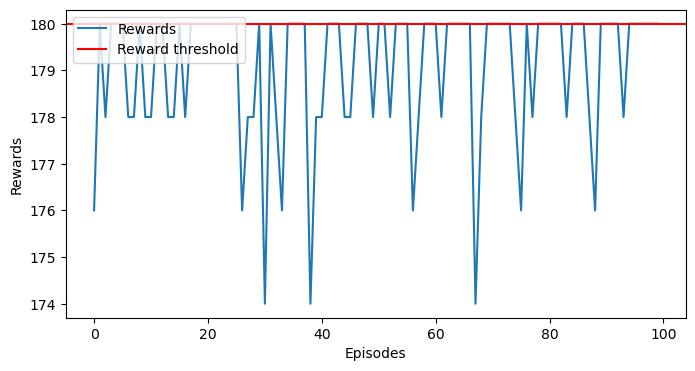

In [57]:
def test_model(ag):
    all_rewards = []
    last_temp = []
    for i_episode in range(100):
        observation, _ = env.reset()

        total_reward = 0
        t=0
        while True:
            #env.render()
            action, _states = model.predict(observation,deterministic = True)
            observation, reward, done, truncated, info = env.step(action)
            total_reward += reward
            t=t+1
            if done:
                last_temp.append(observation)
                all_rewards.append(total_reward)
                break
        #print('Episode {}\tAverage Score: {:.2f} \tFinished in {} timesteps \n '.format(i_episode, total_reward, t+1), end="")

    env.close()

    return all_rewards, last_temp

rewards_test_DQNTemp = test_model(model)
def plot_test(rewards, th):
    plt.figure(figsize=(8,4))
    plt.plot(rewards, label='Rewards')
    plt.axhline(th, color='r', label="Reward threshold")
    plt.xlabel('Episodes')
    plt.ylabel('Rewards')
    plt.legend(loc="upper left")
    plt.show()

plot_test(rewards_test_DQNTemp[0], 180)
mean_reward_dqn = sum(rewards_test_DQNTemp[0]) / len(rewards_test_DQNTemp[0])